In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import chardet

# Détecter l'encodage
with open('spam.csv', 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']
    print(f"Encodage détecté : {encoding}")

# Lire avec l'encodage détecté
df = pd.read_csv('spam.csv', encoding=encoding)

Encodage détecté : Windows-1252


In [3]:
# Voir les colonnes disponibles
print("Colonnes disponibles :", df.columns.tolist())
print("\nPremières lignes :")
print(df.head())
print("\nInfo sur le DataFrame :")
print(df.info())

Colonnes disponibles : ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

Premières lignes :
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

Info sur le DataFrame :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2 

In [ ]:
# Charger et nettoyer le dataset
df = df[['v1', 'v2']].copy()  # Garder seulement les colonnes utiles
df.columns = ['label', 'message']  # Renommer les colonnes

print(f"Dataset loaded: {len(df)} rows")
print(df['label'].value_counts())

Dataset loaded: 5572 rows
label
ham     4825
spam     747
Name: count, dtype: int64


### Encodage des labels

In [5]:
df['label_enc'] = df['label'].map({'ham': 0, 'spam': 1})

### Séparation en train/test

In [6]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['message'].tolist(),
    df['label_enc'].tolist(),
    test_size=0.2,
    random_state=42
)

### Conversion au format HuggingFace Datasets

In [7]:
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})

### Chargement du tokenizer et encodage des textes

In [8]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize(example):
    return tokenizer(example['text'], truncation=True, padding=True)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

c:\Users\adela\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 1115/1115 [00:00<00:00, 15282.07 examples/s]


### Modèle BERT pour classification binaire

In [9]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Configuration de l’entraînement

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    save_total_limit=1
)

### Entraînement avec Trainer

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

trainer.train()

 30%|██▉       | 501/1674 [00:46<01:48, 10.78it/s]

{'loss': 0.0848, 'learning_rate': 3.506571087216249e-05, 'epoch': 0.9}


                                                  
 33%|███▎      | 558/1674 [00:54<01:45, 10.59it/s]

{'eval_loss': 0.17965476214885712, 'eval_runtime': 3.27, 'eval_samples_per_second': 340.979, 'eval_steps_per_second': 42.814, 'epoch': 1.0}


 60%|█████▉    | 1002/1674 [01:35<00:59, 11.31it/s]

{'loss': 0.0249, 'learning_rate': 2.013142174432497e-05, 'epoch': 1.79}


                                                   
 67%|██████▋   | 1116/1674 [01:49<00:47, 11.79it/s]

{'eval_loss': 0.03428542613983154, 'eval_runtime': 3.179, 'eval_samples_per_second': 350.738, 'eval_steps_per_second': 44.039, 'epoch': 2.0}


 90%|████████▉ | 1502/1674 [02:25<00:15, 10.78it/s]

{'loss': 0.0095, 'learning_rate': 5.197132616487455e-06, 'epoch': 2.69}


                                                   
100%|██████████| 1674/1674 [02:44<00:00, 12.13it/s]

{'eval_loss': 0.03668062388896942, 'eval_runtime': 3.1676, 'eval_samples_per_second': 352.003, 'eval_steps_per_second': 44.198, 'epoch': 3.0}


100%|██████████| 1674/1674 [02:45<00:00, 10.10it/s]

{'train_runtime': 165.6389, 'train_samples_per_second': 80.724, 'train_steps_per_second': 10.106, 'train_loss': 0.03573608515937696, 'epoch': 3.0}


TrainOutput(global_step=1674, training_loss=0.03573608515937696, metrics={'train_runtime': 165.6389, 'train_samples_per_second': 80.724, 'train_steps_per_second': 10.106, 'train_loss': 0.03573608515937696, 'epoch': 3.0})

### Évaluation du modèle

In [14]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

print("\n📈 Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=["ham", "spam"]))

100%|██████████| 140/140 [00:03<00:00, 43.06it/s]


📈 Rapport de classification :

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       965
        spam       0.98      0.97      0.98       150

    accuracy                           0.99      1115
   macro avg       0.99      0.99      0.99      1115
weighted avg       0.99      0.99      0.99      1115



### Matrice de confusion

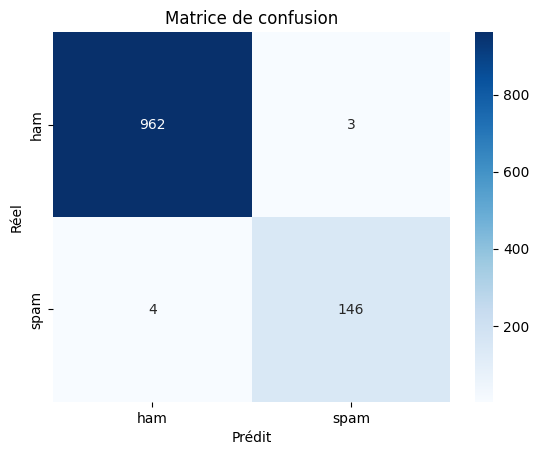

In [19]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["ham", "spam"], yticklabels=["ham", "spam"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()